In [1]:
import numpy as np
import pandas as pd

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data.sampler import SubsetRandomSampler

import matplotlib.pyplot as plt
import time
import copy
from random import shuffle

import tqdm.notebook as tqdm

import sklearn
from sklearn.metrics import accuracy_score, cohen_kappa_score
from sklearn.metrics import classification_report
from PIL import Image
import cv2

import os
import shutil

In [ ]:
!git clone https://github.com/ieee8023/covid-chestxray-dataset.git

Cloning into 'covid-chestxray-dataset'...
Updating files:  28% (330/1174)
Updating files:  29% (341/1174)
Updating files:  30% (353/1174)
Updating files:  31% (364/1174)
Updating files:  32% (376/1174)
Updating files:  33% (388/1174)
Updating files:  34% (400/1174)
Updating files:  35% (411/1174)
Updating files:  36% (423/1174)
Updating files:  37% (435/1174)
Updating files:  37% (441/1174)
Updating files:  38% (447/1174)
Updating files:  39% (458/1174)
Updating files:  40% (470/1174)
Updating files:  41% (482/1174)
Updating files:  42% (494/1174)
Updating files:  43% (505/1174)
Updating files:  44% (517/1174)
Updating files:  45% (529/1174)
Updating files:  45% (536/1174)
Updating files:  46% (541/1174)
Updating files:  47% (552/1174)
Updating files:  48% (564/1174)
Updating files:  49% (576/1174)
Updating files:  49% (584/1174)
Updating files:  50% (587/1174)
Updating files:  51% (599/1174)
Updating files:  52% (611/1174)
Updating files:  53% (623/1174)
Updating files:  54% (634/1174

In [2]:
df = pd.read_csv('C:/Users/lpt-azhar/Downloads/archive/COVID metadata.csv')
selected_df = df[df.FORMAT=="PNG"]
#selected_df = selected_df[(selected_df.view == "AP") | (selected_df.view == "PA")]
selected_df.head(4)

,FILE NAME,FORMAT,SIZE,URL
0,COVID-1,PNG,256*256,https://sirm.org/category/senza-categoria/covi...
1,COVID-2,PNG,256*256,https://sirm.org/category/senza-categoria/covi...
2,COVID-3,PNG,256*256,https://sirm.org/category/senza-categoria/covi...
3,COVID-4,PNG,256*256,https://sirm.org/category/senza-categoria/covi...


In [3]:
images = selected_df.FORMAT.values.tolist()

In [7]:
'''
COVID_PATH = './archive/COVID-19_Radiography_Dataset/COVID' 
NORMAL_PATH = './archive/COVID-19_Radiography_Dataset/Normal' 
'''

"\nCOVID_PATH = './archive/COVID-19_Radiography_Dataset/COVID' \nNORMAL_PATH = './archive/COVID-19_Radiography_Dataset/Normal' \n"

In [4]:
DATA_PATH_COVID = os.listdir('./archive/COVID-19_Radiography_Dataset/COVID')[:100]
DATA_PATH_NORMAL = os.listdir('./archive\COVID-19_Radiography_Dataset/Normal')[:100] 

In [5]:
os.makedirs('./DATA_PATH')

In [6]:
os.makedirs('./DATA_PATH/COVID')
os.makedirs('./DATA_PATH/NORMAL')

In [5]:
for image in DATA_PATH_COVID :
    shutil.copy(os.path.join('./archive/COVID-19_Radiography_Dataset/COVID'[:100], image), os.path.join('./DATA_PATH/COVID', image))

In [6]:
for image in DATA_PATH_NORMAL :
    shutil.copy(os.path.join('./archive/COVID-19_Radiography_Dataset/Normal'[:100], image), os.path.join('./DATA_PATH/NORMAL', image))

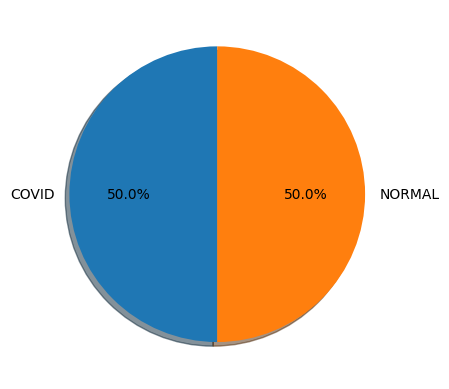

In [7]:
class_names = os.listdir('./DATA_PATH')
image_count = {}
for i in class_names:
    image_count[i] = len(os.listdir(os.path.join('./DATA_PATH',i)))

#Plotting Distribution of Each Classes
fig1, ax1 = plt.subplots()
ax1.pie(image_count.values(),
        labels = image_count.keys(),
        shadow=True,
        autopct = '%1.1f%%',
        startangle=90)
plt.show()

C:\Users\lpt-azhar\AppData\Local\Temp\ipykernel_2832\4222332509.py:10: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


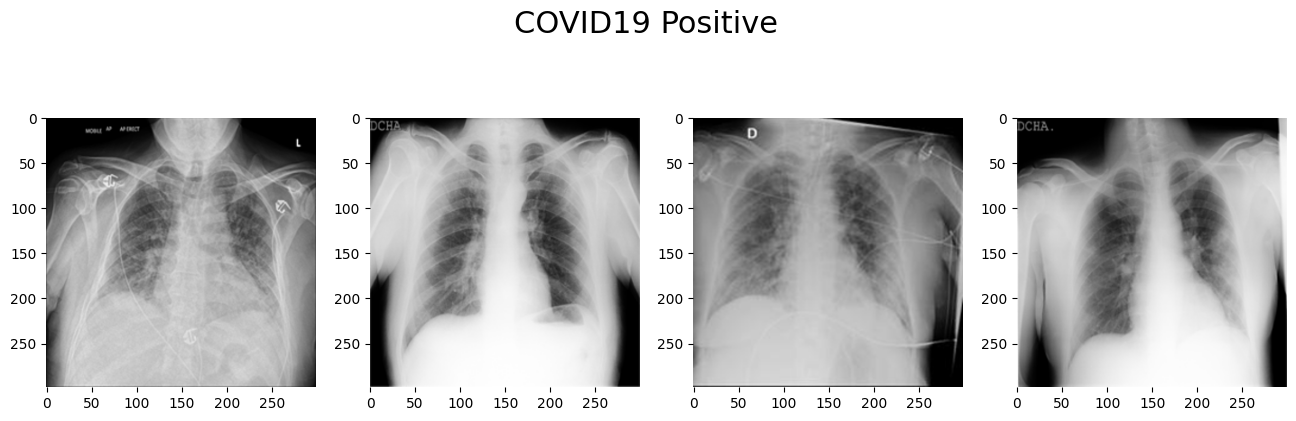

In [8]:
fig = plt.figure(figsize=(16,5))
fig.suptitle("COVID19 Positive", size=22)
img_paths = os.listdir('./DATA_PATH/COVID')
shuffle(img_paths)

for i,image in enumerate(img_paths[:4]):
    img = cv2.imread(os.path.join('./DATA_PATH/COVID', image))
    plt.subplot(1,4, i+1, frameon=False)
    plt.imshow(img)
fig.show()

C:\Users\lpt-azhar\AppData\Local\Temp\ipykernel_2832\2224017699.py:10: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


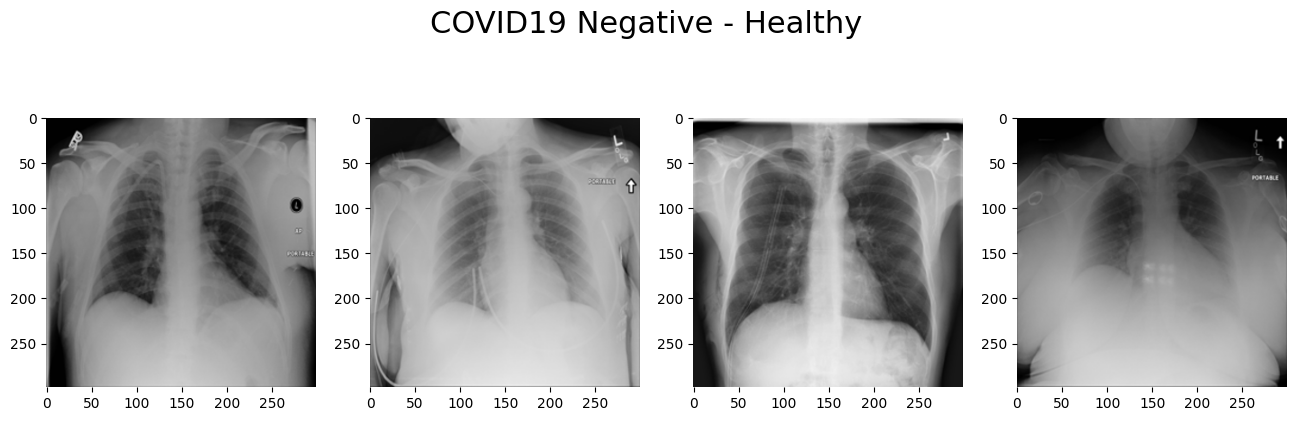

In [9]:
fig = plt.figure(figsize=(16,5))
fig.suptitle("COVID19 Negative - Healthy", size=22)
img_paths = os.listdir('./DATA_PATH/NORMAL')
shuffle(img_paths)

for i,image in enumerate(img_paths[:4]):
    img = cv2.imread(os.path.join('./DATA_PATH/NORMAL', image))
    plt.subplot(1,4, i+1, frameon=False)
    plt.imshow(img)
fig.show()

In [10]:
#Statistics Based on ImageNet Data for Normalisation
mean_nums = [0.485, 0.456, 0.406]
std_nums = [0.229, 0.224, 0.225]

data_transforms = {"train":transforms.Compose([
                                transforms.Resize((224,224)), #Resizes all images into same dimension
                                transforms.RandomRotation(10), # Rotates the images upto Max of 10 Degrees
                                transforms.RandomHorizontalFlip(p=0.4), #Performs Horizantal Flip over images 
                                transforms.ToTensor(), # Coverts into Tensors
                                transforms.Normalize(mean = mean_nums, std=std_nums)]), # Normalizes
                    "val": transforms.Compose([
                                transforms.Resize((224,224)),
                                transforms.CenterCrop(224), #Performs Crop at Center and resizes it to 150x150
                                transforms.ToTensor(),
                                transforms.Normalize(mean=mean_nums, std = std_nums)
                    ])}

In [11]:
def load_split_train_test(datadir, valid_size = .2):
    train_data = datasets.ImageFolder(datadir,       
                    transform=data_transforms['train']) #Picks up Image Paths from its respective folders and label them
    test_data = datasets.ImageFolder(datadir,
                    transform=data_transforms['val'])
    num_train = len(train_data)
    indices = list(range(num_train))
    split = int(np.floor(valid_size * num_train))
    np.random.shuffle(indices)
    train_idx, test_idx = indices[split:], indices[:split]
    dataset_size = {"train":len(train_idx), "val":len(test_idx)}
    train_sampler = SubsetRandomSampler(train_idx) # Sampler for splitting train and val images
    test_sampler = SubsetRandomSampler(test_idx)
    trainloader = torch.utils.data.DataLoader(train_data,
                   sampler=train_sampler, batch_size=8) # DataLoader provides data from traininng and validation in batches
    testloader = torch.utils.data.DataLoader(test_data,
                   sampler=test_sampler, batch_size=8)
    return trainloader, testloader, dataset_size
trainloader, valloader, dataset_size = load_split_train_test('./DATA_PATH', .2)
dataloaders = {"train":trainloader, "val":valloader}
data_sizes = {x: len(dataloaders[x].sampler) for x in ['train','val']}
class_names = trainloader.dataset.classes
print(len(class_names))
#print(data_sizes)

2


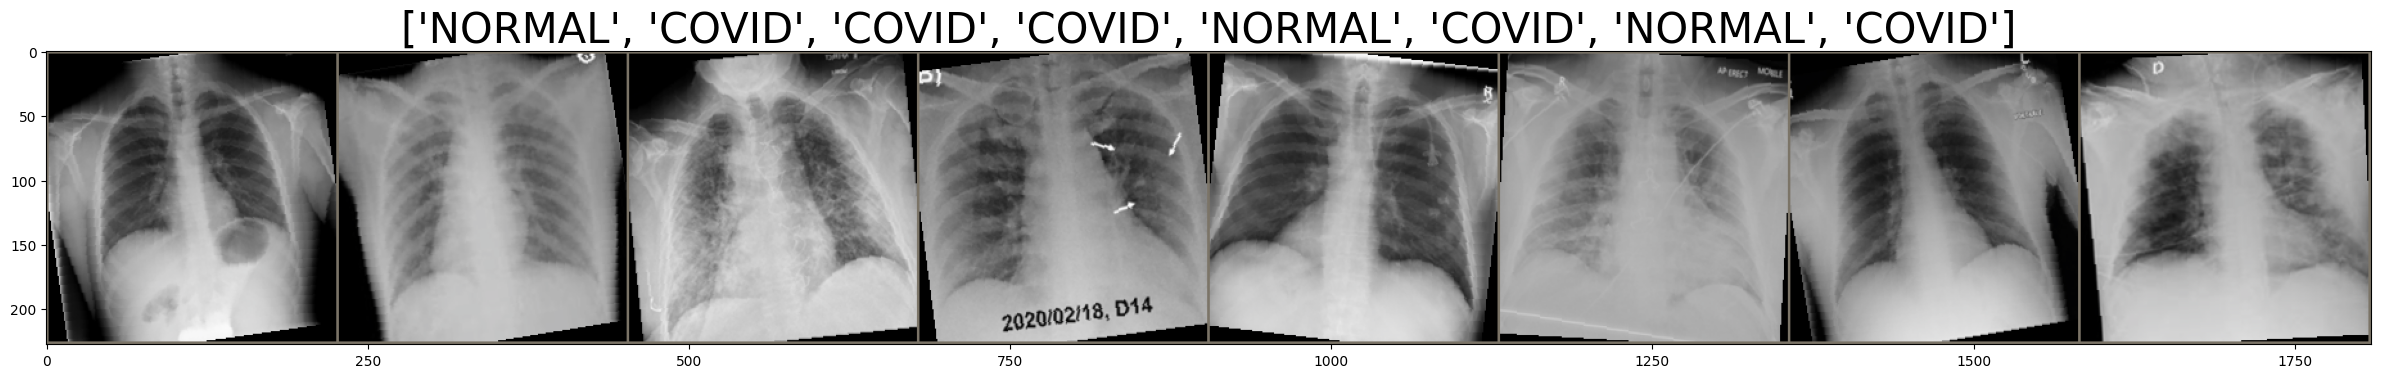

In [12]:
def imshow(inp, size =(30,30), title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = mean_nums
    std = std_nums
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.figure(figsize=size)
    plt.imshow(inp)
    if title is not None:
        plt.title(title, size=30)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [13]:
print(inputs.size())
print(inputs)

torch.Size([8, 3, 224, 224])
tensor([[[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          ...,
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],

         [[-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          ...,
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357]],

         [[-1.8044, -1.8044, -1.8044,  ..., -1.8044, -1.8044, -1.8044],
 

In [14]:
if torch.cuda.is_available():
    device=torch.device("cuda:0")
    print("Training on GPU... Ready for HyperJump...")
else:
    device = torch.device("cpu")
    print("Training on CPU... May the force be with you...")

Training on CPU... May the force be with you...


In [15]:
torch.cuda.empty_cache()

In [16]:
class VGG16(nn.Module):
    def __init__(self, num_classes=10):
        super(VGG16, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU())
        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(), 
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU())
        self.layer4 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer5 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU())
        self.layer6 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU())
        self.layer7 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer8 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer9 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer10 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer11 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer12 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer13 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(7*7*512, 4096),
            nn.ReLU())
        self.fc1 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU())
        self.fc2= nn.Sequential(
            nn.Linear(4096, num_classes))
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = self.layer6(out)
        out = self.layer7(out)
        out = self.layer8(out)
        out = self.layer9(out)
        out = self.layer10(out)
        out = self.layer11(out)
        out = self.layer12(out)
        out = self.layer13(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

In [21]:
'''
def CNN_Model(pretrained=True):
    model = models.vgg19(pretrained=pretrained) # Returns Defined Densenet model with weights trained on ImageNet
    num_ftrs = model.classifier[0].in_features # Get the number of features output from CNN layer
    model.classifier = nn.Linear(num_ftrs, len(class_names)) # Overwrites the Classifier layer with custom defined layer for transfer learning
    model = model.to(device) # Transfer the Model to GPU if available
    return model
'''

model = VGG16(len(class_names)).to(device)
print(model)
# specify loss function (categorical cross-entropy loss)
criterion = nn.CrossEntropyLoss() 

# Specify optimizer which performs Gradient Descent
optimizer = optim.SGD(model.parameters(), lr=0.005, weight_decay=0.005, momentum=0.9) 
# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1) # Learning Scheduler 

history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

VGG16(
  (layer1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer2): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer4): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=

In [22]:
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Number of trainable parameters: \n{}".format(pytorch_total_params))

Number of trainable parameters: 
134277186


In [23]:
outputs = model(inputs)
print(outputs)

tensor([[-0.0909,  0.0902],
        [ 0.5519,  0.0297],
        [ 0.2569,  0.1328],
        [ 0.3169,  0.1049],
        [-0.0417,  0.1234],
        [-0.1293,  0.0791],
        [ 0.1195,  0.0494],
        [ 0.1025,  0.1133]], grad_fn=<AddmmBackward0>)


In [32]:
def train_model(model, criterion, optimizer, scheduler, num_epochs):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = np.inf

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            current_loss = 0.0
            current_corrects = 0
            current_kappa = 0
            val_kappa = list()

            for inputs, labels in tqdm.tqdm(dataloaders[phase], desc=phase, leave=False):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # We need to zero the gradients in the Cache.
                optimizer.zero_grad()

                # Time to carry out the forward training poss
                # We only need to log the loss stats if we are in training phase
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                if phase == 'train':
                    scheduler.step()

                # We want variables to hold the loss statistics
                current_loss += loss.item() * inputs.size(0)
                current_corrects += torch.sum(preds == labels.data)
                val_kappa.append(cohen_kappa_score(preds.cpu().numpy(), labels.data.cpu().numpy()))
            epoch_loss = current_loss / data_sizes[phase]
            epoch_acc = current_corrects.double() / data_sizes[phase]
            if phase == 'val':
                epoch_kappa = np.mean(val_kappa)
                print('{} Loss: {:.4f} | {} Accuracy: {:.4f} | Kappa Score: {:.4f}'.format(
                    phase, epoch_loss, phase, epoch_acc, epoch_kappa))
                history['val_loss'].append(epoch_loss)
                history['val_acc'].append(epoch_acc)
            else:
                print('{} Loss: {:.4f} | {} Accuracy: {:.4f}'.format(
                    phase, epoch_loss, phase, epoch_acc))
                history['train_loss'].append(epoch_loss)
                history['train_acc'].append(epoch_acc)

            # EARLY STOPPING
            if phase == 'val' and epoch_loss < best_loss:
                print('Val loss Decreased from {:.4f} to {:.4f} \nSaving Weights... '.format(best_loss, epoch_loss))
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())

        print() 
        
    time_since = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_since // 60, time_since % 60))
    print('Best val loss: {:.4f}'.format(best_loss))

    # Now we'll load in the best model weights and return it
    #model.load_state_dict(best_model_wts)
    #return model

In [33]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_handeled = 0
    ax = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
    
            for j in range(inputs.size()[0]):
                images_handeled += 1    
                ax = plt.subplot(num_images//2, 2, images_handeled)
                ax.axis('off')
                ax.set_title('Actual: {} predicted: {}'.format(class_names[labels[j].item()],class_names[preds[j]]))
                imshow(inputs.cpu().data[j], (5,5))

                if images_handeled == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [54]:
def reset_weights(m):
    if hasattr(m, 'reset_parameters'):
        m.reset_parameters()

model.apply(reset_weights)

VGG16(
  (layer1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer2): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer4): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=

In [34]:
base_model = train_model(model, criterion, optimizer, exp_lr_scheduler, num_epochs=20)

Epoch 1/20
----------


train:   0%|          | 0/20 [00:00<?, ?it/s]

train Loss: 0.6168 | train Accuracy: 0.6375


val:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 0.6535 | val Accuracy: 0.7000 | Kappa Score: 0.4000
Val loss Decreased from inf to 0.6535 
Saving Weights... 

Epoch 2/20
----------


train:   0%|          | 0/20 [00:00<?, ?it/s]

train Loss: 0.6417 | train Accuracy: 0.6875


val:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 0.6545 | val Accuracy: 0.7250 | Kappa Score: 0.4233

Epoch 3/20
----------


train:   0%|          | 0/20 [00:00<?, ?it/s]

train Loss: 0.6499 | train Accuracy: 0.5875


val:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 0.6544 | val Accuracy: 0.7250 | Kappa Score: 0.4269

Epoch 4/20
----------


train:   0%|          | 0/20 [00:00<?, ?it/s]

train Loss: 0.7147 | train Accuracy: 0.5625


val:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 0.6544 | val Accuracy: 0.7000 | Kappa Score: 0.3733

Epoch 5/20
----------


train:   0%|          | 0/20 [00:00<?, ?it/s]

train Loss: 0.6451 | train Accuracy: 0.5813


val:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 0.6542 | val Accuracy: 0.6750 | Kappa Score: 0.3386

Epoch 6/20
----------


train:   0%|          | 0/20 [00:00<?, ?it/s]

train Loss: 0.6889 | train Accuracy: 0.5875


val:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 0.6540 | val Accuracy: 0.7500 | Kappa Score: 0.4952

Epoch 7/20
----------


train:   0%|          | 0/20 [00:00<?, ?it/s]

train Loss: 0.6044 | train Accuracy: 0.6937


val:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 0.6549 | val Accuracy: 0.7250 | Kappa Score: 0.4167

Epoch 8/20
----------


train:   0%|          | 0/20 [00:00<?, ?it/s]

train Loss: 0.6538 | train Accuracy: 0.6438


val:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 0.6546 | val Accuracy: 0.7000 | Kappa Score: 0.3857

Epoch 9/20
----------


train:   0%|          | 0/20 [00:00<?, ?it/s]

train Loss: 0.6419 | train Accuracy: 0.6250


val:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 0.6553 | val Accuracy: 0.7250 | Kappa Score: 0.4167

Epoch 10/20
----------


train:   0%|          | 0/20 [00:00<?, ?it/s]

train Loss: 0.6851 | train Accuracy: 0.5625


val:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 0.6536 | val Accuracy: 0.7000 | Kappa Score: 0.3452

Epoch 11/20
----------


train:   0%|          | 0/20 [00:00<?, ?it/s]

train Loss: 0.6462 | train Accuracy: 0.5813


val:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 0.6568 | val Accuracy: 0.7000 | Kappa Score: 0.3488

Epoch 12/20
----------


train:   0%|          | 0/20 [00:00<?, ?it/s]

train Loss: 0.6840 | train Accuracy: 0.5813


val:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 0.6553 | val Accuracy: 0.7250 | Kappa Score: 0.4381

Epoch 13/20
----------


train:   0%|          | 0/20 [00:00<?, ?it/s]

train Loss: 0.6521 | train Accuracy: 0.5875


val:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 0.6551 | val Accuracy: 0.7000 | Kappa Score: 0.3100

Epoch 14/20
----------


train:   0%|          | 0/20 [00:00<?, ?it/s]

train Loss: 0.6557 | train Accuracy: 0.6312


val:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 0.6547 | val Accuracy: 0.7000 | Kappa Score: 0.3467

Epoch 15/20
----------


train:   0%|          | 0/20 [00:00<?, ?it/s]

train Loss: 0.6745 | train Accuracy: 0.6000


val:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 0.6540 | val Accuracy: 0.7500 | Kappa Score: 0.3933

Epoch 16/20
----------


train:   0%|          | 0/20 [00:00<?, ?it/s]

train Loss: 0.6576 | train Accuracy: 0.5938


val:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 0.6538 | val Accuracy: 0.7250 | Kappa Score: 0.4659

Epoch 17/20
----------


train:   0%|          | 0/20 [00:00<?, ?it/s]

train Loss: 0.6332 | train Accuracy: 0.6125


val:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 0.6537 | val Accuracy: 0.7000 | Kappa Score: 0.3980

Epoch 18/20
----------


train:   0%|          | 0/20 [00:00<?, ?it/s]

train Loss: 0.6506 | train Accuracy: 0.6312


val:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 0.6540 | val Accuracy: 0.7000 | Kappa Score: 0.3751

Epoch 19/20
----------


train:   0%|          | 0/20 [00:00<?, ?it/s]

train Loss: 0.6614 | train Accuracy: 0.6250


val:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 0.6549 | val Accuracy: 0.7250 | Kappa Score: 0.3051

Epoch 20/20
----------


train:   0%|          | 0/20 [00:00<?, ?it/s]

train Loss: 0.6896 | train Accuracy: 0.5500


val:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 0.6544 | val Accuracy: 0.7250 | Kappa Score: 0.4290

Training complete in 41m 54s
Best val loss: 0.6535


In [43]:
#del history['train_loss'][:5]
print(len(history['train_loss']))

20


In [46]:
#del history['val_loss'][:5]
print(len(history['val_loss']))

20


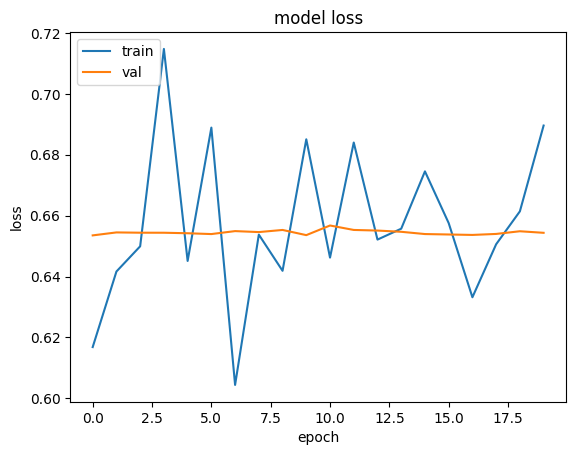

In [47]:
plt.plot(history['train_loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [50]:
#del history['train_acc'][:5]
print(len(history['train_acc']))

20


In [53]:
#del history['val_acc'][:5]
print(len(history['val_acc']))

20


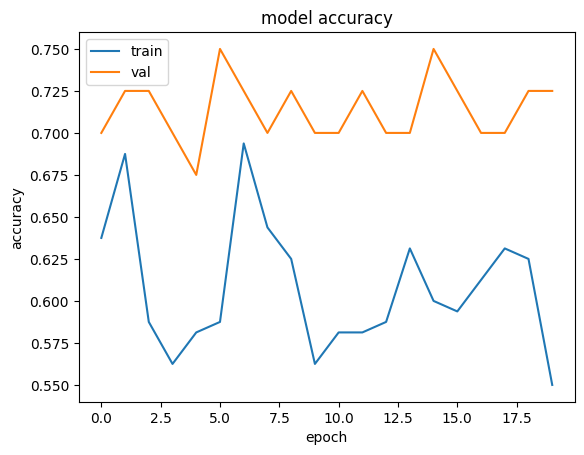

In [54]:
plt.plot(history['train_acc'])
plt.plot(history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

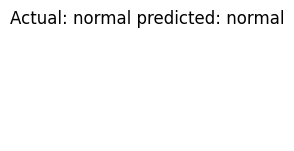

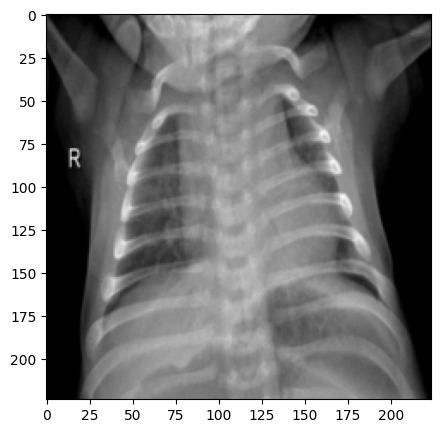

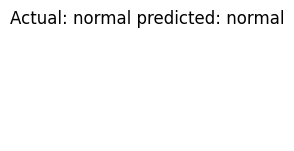

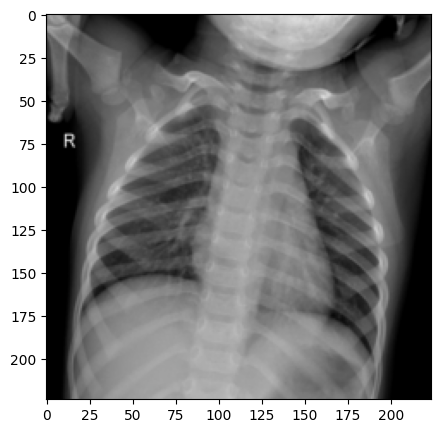

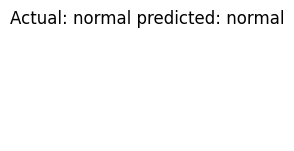

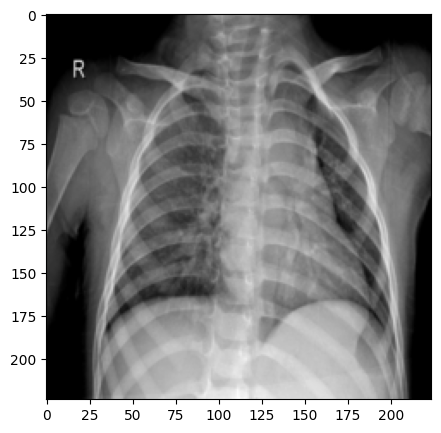

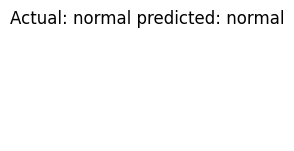

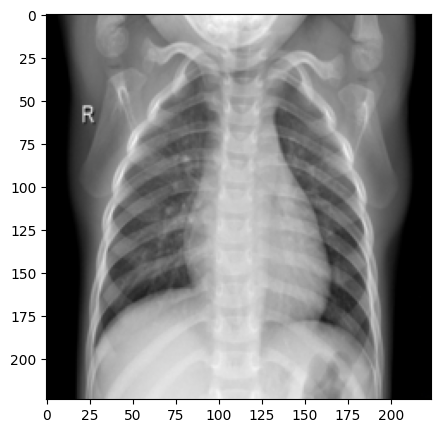

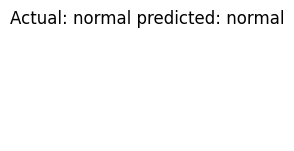

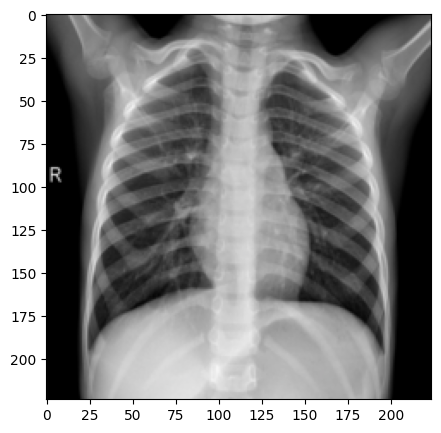

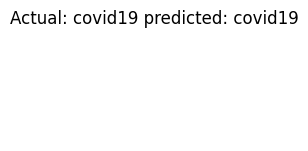

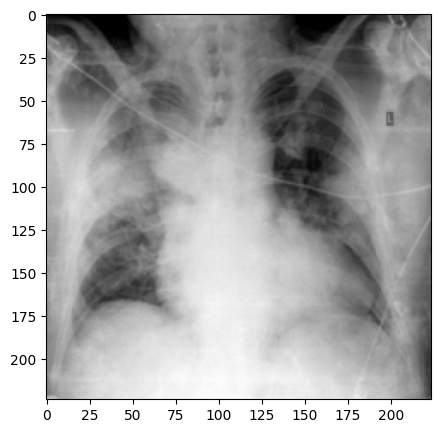

In [59]:
visualize_model(base_model)
plt.show()

In [ ]:
os.makedirs('./COVID19-DATASET/test/covid19')
os.makedirs('./COVID19-DATASET/test/normal')

In [60]:
COVID_TEST = './COVID-19 Radiography Database/COVID-19'
NORMAL_TEST = './COVID-19 Radiography Database/NORMAL'

for image in os.listdir(COVID_TEST)[:100]:
    shutil.copy(os.path.join(COVID_TEST, image), os.path.join('./COVID19-DATASET/test/covid19', image))
for image in os.listdir(NORMAL_TEST)[:100]:
    shutil.copy(os.path.join(NORMAL_TEST, image), os.path.join('./COVID19-DATASET/test/normal', image))

In [61]:
TEST_DATA_PATH = './COVID19-DATASET/test/'

test_transforms = transforms.Compose([
                                      transforms.Resize((150,150)),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=mean_nums, std=std_nums)
])


test_image = datasets.ImageFolder(TEST_DATA_PATH, transform=test_transforms)

testloader = torch.utils.data.DataLoader(test_image, batch_size=1)

In [63]:
y_pred_list = []
y_true_list = []
with torch.no_grad():
    for x_batch, y_batch in tqdm.tqdm(testloader, leave=False):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        y_test_pred = base_model(x_batch)
        y_test_pred = torch.log_softmax(y_test_pred, dim=1)
        _, y_pred_tag = torch.max(y_test_pred, dim = 1)
        y_pred_list.append(y_pred_tag.cpu().numpy())
        y_true_list.append(y_batch.cpu().numpy())

  0%|          | 0/200 [00:00<?, ?it/s]

In [64]:
y_pred_list = [i[0] for i in y_pred_list]
y_true_list = [i[0] for i in y_true_list]

In [65]:
print(classification_report(y_true_list, y_pred_list))

              precision    recall  f1-score   support

           0       0.95      0.84      0.89       100
           1       0.86      0.96      0.91       100

    accuracy                           0.90       200
   macro avg       0.91      0.90      0.90       200
weighted avg       0.91      0.90      0.90       200



In [66]:
import matplotlib.pyplot as plt
import numpy as np
import itertools
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

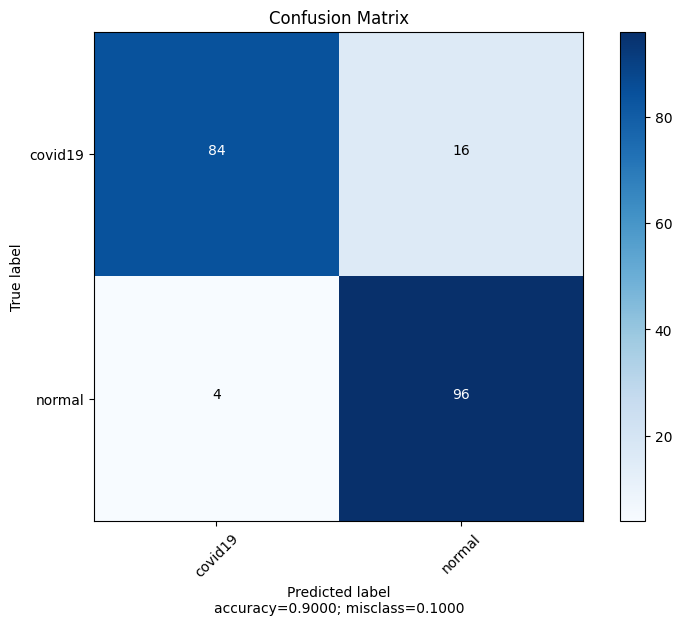

In [67]:
from sklearn.metrics import confusion_matrix

cm =  confusion_matrix(y_true_list, y_pred_list)

plot_confusion_matrix(cm = cm, 
                      normalize    = False,
                      target_names = ['covid19','normal'],
                      title        = "Confusion Matrix")